In [2]:
!pip install geopandas

     |████████████████████████████████| 931kB 2.7MB/s 
     |████████████████████████████████| 14.7MB 308kB/s 
     |████████████████████████████████| 10.4MB 31.5MB/s 


In [0]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import geopandas
import pandas as pd
import numpy as np
import folium
import gc
from folium.plugins import TimeSliderChoropleth
from scipy.signal import find_peaks

In [0]:
PATH_DATA = '/content/drive/My Drive/covid19-spain/COVID_19_SPAIN_OFFICIAL_DATA.xlsx'
PATH_GEO_JSON = '/content/drive/My Drive/covid19-spain/shapefiles_ccaa_espana.geojson'

In [0]:
def get_hex_colors(df, data_to_color, cmap = matplotlib.cm.Reds, log = False):
    
    '''
    This function takes the following arguments
        1. df:pandas DataFrame with the data.
        2. data_to_color: the column name with data based on which we want to create the color scale.
        3. cmap: colors you want to plot. You can use this to communicate different messages. For example: greens --> good, greys --> deaths.
                default is matplotlib.cm.Reds
                more about colormaps: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
        3. log: if data has huge outliers, we can create the color map with a logarithic normalization. This way, the outliers won't "pale" our other data.
                default is False.
        
    '''
    
    cmap = cmap # define the color pallete you want. You can use Reds, Blues, Greens etc
    my_values = df[data_to_color] # get the value you wan to convert to colors
    
    mini = min(my_values) # get the min to normalize
    maxi= max(my_values) # get the max to normalize
    
    LOGMIN = 0.01 # arbitrary lower bound for log scale
    
    if log: 
        norm = matplotlib.colors.LogNorm(vmin=max(mini,LOGMIN), vmax=maxi) # normalize log data
    else:
        norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi) # create a color range
        
    colors = {value:matplotlib.colors.rgb2hex(cmap(norm(value))[:3]) for value in sorted(list(set(my_values)))} # create a dictionary with the total_infected or deaths as keys and colors as values
    
    return colors

In [0]:
def get_hex_colors_2(value, cats):
    '''
    Color paletter used from this website:
    
    https://colorbrewer2.org/#type=sequential&scheme=Reds&n=9
    
    The color selection will be based on the percentile each value is in.
    '''
    if value == 0:
        return "#FFFFFF"
    elif value in cats[0]:
        return "#fff5f0"
    elif value in cats[1]:
        return "#fee0d2"
    elif value in cats[2]:
        return "#fcbba1"
    elif value in cats[3]:
        return "#fc9272"
    elif value in cats[4]:
        return "#fb6a4a"
    elif value in cats[5]:
        return "#ef3b2c"
    elif value in cats[6]:
        return "#cb181d"
    elif value in cats[7]:
        return "#a50f15"
    elif value in cats[8]:
        return "#67000d"
    else:
        return "#000000"

Datos para mapear

In [0]:
d_ccaa = {
'Andalucía': 'Andalucía',
'Aragón': 'Aragón',
'Asturias': 'Principado de Asturias',
'Baleares': 'Islas Baleares',
'Canarias': 'Islas Canarias',
'Cantabria':'Cantabria',
'Castilla La Mancha': 'Castilla-La Mancha',
'Castilla y León': 'Castilla y León',
'Cataluña': 'Cataluña',
'Ceuta': 'Ceuta y Melilla',
'C. Valenciana': 'Comunidad Valenciana',
'Extremadura': 'Extremadura',
'Galicia': 'Galicia',
'Madrid': 'Comunidad de Madrid',
'Melilla': 'Ceuta y Melilla',
'Murcia': 'Región de Murcia',
'Navarra': 'Comunidad Foral de Navarra',
'País Vasco': 'País Vasco',
'La Rioja': 'La Rioja'
}

In [0]:
d_ccaa_id = {
'Andalucía': 1,
'Aragón' : 2,
'Principado de Asturias': 3,
'Islas Baleares': 4,
'Islas Canarias': 5,
'Cantabria': 6,
'Castilla-La Mancha': 7,
'Castilla y León': 8,
'Cataluña': 9,
'Ceuta y Melilla': 10,
'Comunidad Valenciana': 11,
'Extremadura': 12,
'Galicia': 13,
'Comunidad de Madrid' : 14,
'Ceuta y Melilla': 15,
'Región de Murcia': 16,
'Comunidad Foral de Navarra': 17,
'País Vasco': 18,
'La Rioja': 19
}

In [0]:
d_ccaa_population = {
'Andalucía': 8414240,
'Aragón' : 1319291,
'Principado de Asturias': 1022800,
'Islas Baleares': 1149460,
'Islas Canarias': 2153389,
'Cantabria': 581078,
'Castilla-La Mancha': 2032863,
'Castilla y León': 2399548,
'Cataluña': 7675217,
'Ceuta y Melilla': 171264,
'Comunidad Valenciana': 5003769,
'Extremadura': 1067710,
'Galicia': 2699499,
'Comunidad de Madrid' : 6663394,
'Ceuta y Melilla': 171264,
'Región de Murcia': 1493898,
'Comunidad Foral de Navarra': 654214,
'País Vasco': 2207776,
'La Rioja': 316798
}

In [11]:
df = pd.read_excel(PATH_DATA)
df.fillna(0, inplace = True)
df["CCAA_for_Folium"] = df["CCAA"].map(d_ccaa)
df["id"] = df["CCAA_for_Folium"].map(d_ccaa_id)
df["Population"] = df["CCAA_for_Folium"].map(d_ccaa_population)
df["DATE_for_Folium"] = (df["DATE"].astype(int)// 10**9).astype('U10')
df.drop(columns='LINKS', inplace=True)
df.head() # I will add all the missing data in the following days

,CCAA Codigo ISO,CCAA,DATE,TOTAL_INFECTED,REQUIERED_HOSPITALIZATION,REQUIERED_ADVANCED_CARE,TOTAL_DEATHS,CURED,CCAA_for_Folium,id,Population,DATE_for_Folium
0,AN,Andalucía,2020-02-20,0.0,0.0,0.0,0.0,0.0,Andalucía,1,8414240,1582156800
1,AR,Aragón,2020-02-20,0.0,0.0,0.0,0.0,0.0,Aragón,2,1319291,1582156800
2,AS,Asturias,2020-02-20,0.0,0.0,0.0,0.0,0.0,Principado de Asturias,3,1022800,1582156800
3,IB,Baleares,2020-02-20,1.0,0.0,0.0,0.0,0.0,Islas Baleares,4,1149460,1582156800
4,CN,Canarias,2020-02-20,1.0,0.0,0.0,0.0,0.0,Islas Canarias,5,2153389,1582156800


Reordenamos las columnas y nos quedamos con las que nos interesan

In [12]:
df = df[["id", "CCAA", "CCAA_for_Folium", "DATE", "DATE_for_Folium", "TOTAL_INFECTED", "REQUIERED_HOSPITALIZATION", "REQUIERED_ADVANCED_CARE", "TOTAL_DEATHS", "CURED","Population"]]
df.head()

,id,CCAA,CCAA_for_Folium,DATE,DATE_for_Folium,TOTAL_INFECTED,REQUIERED_HOSPITALIZATION,REQUIERED_ADVANCED_CARE,TOTAL_DEATHS,CURED,Population
0,1,Andalucía,Andalucía,2020-02-20,1582156800,0.0,0.0,0.0,0.0,0.0,8414240
1,2,Aragón,Aragón,2020-02-20,1582156800,0.0,0.0,0.0,0.0,0.0,1319291
2,3,Asturias,Principado de Asturias,2020-02-20,1582156800,0.0,0.0,0.0,0.0,0.0,1022800
3,4,Baleares,Islas Baleares,2020-02-20,1582156800,1.0,0.0,0.0,0.0,0.0,1149460
4,5,Canarias,Islas Canarias,2020-02-20,1582156800,1.0,0.0,0.0,0.0,0.0,2153389


Preparamos los datos geográficos

In [13]:
gdf = geopandas.read_file(PATH_GEO_JSON)
gdf["id"] = gdf["name_1"].map(d_ccaa_id) # create a numerical id for each ccaa
gdf = gdf[["id", "shape_leng","shape_area","geometry"]] # extract the id and the geometry (coordinates of each ccaa)
gdf["geometry"] = gdf["geometry"].simplify(0.1, preserve_topology = False)
gdf.head()

,id,shape_leng,shape_area,geometry
0,1,26.409069,8.916415,"POLYGON ((-6.97403 37.29625, -6.94847 37.16375..."
1,2,15.095307,5.150835,"POLYGON ((-0.74582 42.92190, -0.01455 42.68477..."
2,6,9.085137,0.588004,"POLYGON ((-3.58542 43.51486, -3.15148 43.30683..."
3,8,28.330904,10.200456,"POLYGON ((-4.84928 43.17701, -3.97881 42.75806..."
4,7,23.325765,8.330905,"POLYGON ((-2.90659 41.32764, -2.41884 41.05772..."


In [0]:
gdf_madrid = gdf[gdf['id']==14]

In [24]:
gdf_madrid

,id,shape_leng,shape_area,geometry
14,14,7.57315,0.852864,"POLYGON ((-3.53646 41.16038, -3.39455 41.00026..."


In [0]:
#m = folium.Map(location = (40.4378698,-3.8196192), zoom_start = 9.5, tiles='Stamen Terrain')
m = folium.Map(location = (40, 0), zoom_start = 5.5, tiles='Stamen Terrain')

folium.Choropleth(
    geo_data = gdf,
    name = 'choropleth',
    data = df,
    columns = ['id', 'TOTAL_INFECTED'],
    key_on='feature.properties.id',
    fill_color='RdPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name = 'Total infected cases in Spain by region'
).add_to(m)

m

In [65]:
#----------------------------------------------------------------------------------
data_to_color = "TOTAL_DEATHS"
cats, bins =  pd.qcut(df[data_to_color].unique()[np.argsort(df[data_to_color].unique())], q = 9, retbins = True)
cats = cats.unique()

#----------------------------------------------------------------------------------

# value we will iterate in order to create the styledict
ccaas = list(df["id"].unique())
dates = list(df["DATE_for_Folium"].unique())

# create the color dict and color column
df["COLORS"] = df[data_to_color].apply(get_hex_colors_2, args = [cats]) # we create a colum in the df so that we can iterate and create the styledict

# creates the styledict for the map
styledict = {}

# iterate the populate the styledict
for ccaa in ccaas:
    styledict[str(ccaa)] = {date: {'color': df[(df["id"] == ccaa) & (df["DATE_for_Folium"] == date)]["COLORS"].values[0],
                                   'opacity': 0.6} for date in dates}
    
# creates and renders the Folium map
m = folium.Map(location=(40, 0), tiles='OpenStreetMap', zoom_start=6)

g = TimeSliderChoropleth(
    gdf.set_index("id").to_json(), # get's the coordinates for each id 
    styledict = styledict # styledict contains for each id the timestamp and the color to plot.
)

m.add_child(g)

#--------------------------------------------------------------------------------------
# Let's create a legend for folium
# https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac81cd

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Legend</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#FFFFFF;opacity:0.6;'></span>No cases</li>
    <li><span style='background:#fff5f0;opacity:0.6;'></span>1 Quantile</li>
    <li><span style='background:#fee0d2;opacity:0.6;'></span>2 Quantile</li>
    <li><span style='background:#fcbba1;opacity:0.6;'></span>3 Quantile</li>
    <li><span style='background:#fc9272;opacity:0.6;'></span>4 Quantile</li>
    <li><span style='background:#fb6a4a;opacity:0.6;'></span>5 Quantile</li>
    <li><span style='background:#ef3b2c;opacity:0.6;'></span>6 Quantile</li>
    <li><span style='background:#cb181d;opacity:0.6;'></span>7 Quantile</li>
    <li><span style='background:#a50f15;opacity:0.6;'></span>8 Quantile</li>
    <li><span style='background:#67000d;opacity:0.6;'></span>9 Quantile</li>
    <li><span style='background:#000000;opacity:0.6;'></span>Other</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

In [25]:
df.head()

,id,CCAA,CCAA_for_Folium,DATE,DATE_for_Folium,TOTAL_INFECTED,REQUIERED_HOSPITALIZATION,REQUIERED_ADVANCED_CARE,TOTAL_DEATHS,CURED,Population
0,1,Andalucía,Andalucía,2020-02-20,1582156800,0.0,0.0,0.0,0.0,0.0,8414240
1,2,Aragón,Aragón,2020-02-20,1582156800,0.0,0.0,0.0,0.0,0.0,1319291
2,3,Asturias,Principado de Asturias,2020-02-20,1582156800,0.0,0.0,0.0,0.0,0.0,1022800
3,4,Baleares,Islas Baleares,2020-02-20,1582156800,1.0,0.0,0.0,0.0,0.0,1149460
4,5,Canarias,Islas Canarias,2020-02-20,1582156800,1.0,0.0,0.0,0.0,0.0,2153389


# Global

In [0]:
import math

millnames = ['',' Miles',' Millones',' Billones',' Trillones']

def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:.0f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

In [0]:
df_ccaa = df.groupby('CCAA')[['TOTAL_INFECTED', 'REQUIERED_HOSPITALIZATION', 'TOTAL_DEATHS', 'CURED']].sum()
df_ccaa['Population'] = df.groupby('CCAA')['Population'].max()
df_ccaa = df_ccaa.reset_index()

In [41]:
import plotly.express as px
fig = px.pie(df_ccaa, values='Population', names='CCAA', title='Población de España: '+ str(millify(df_ccaa['Population'].sum())))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

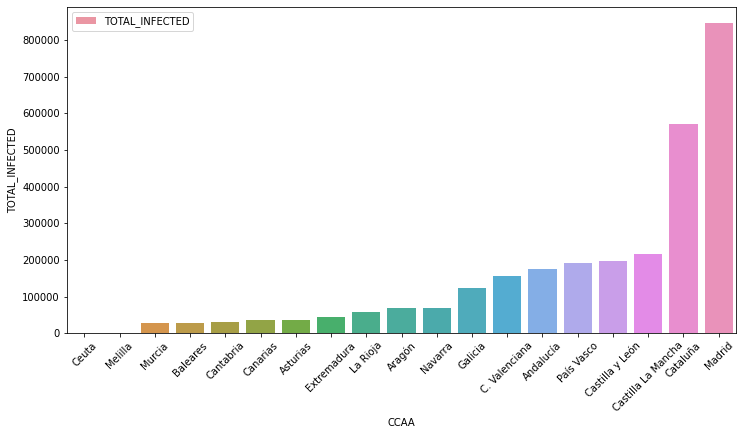

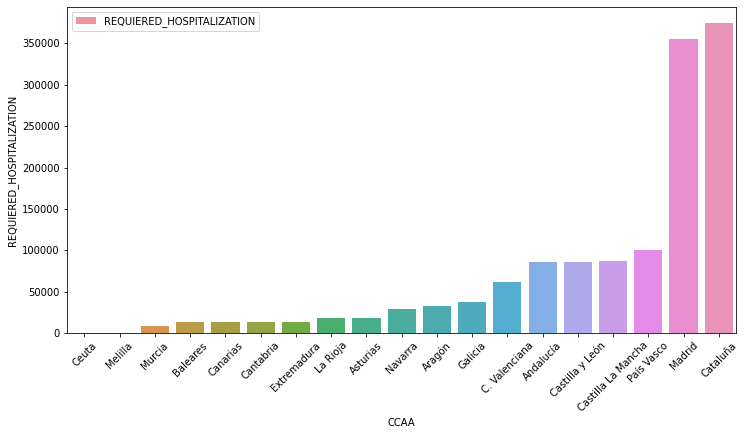

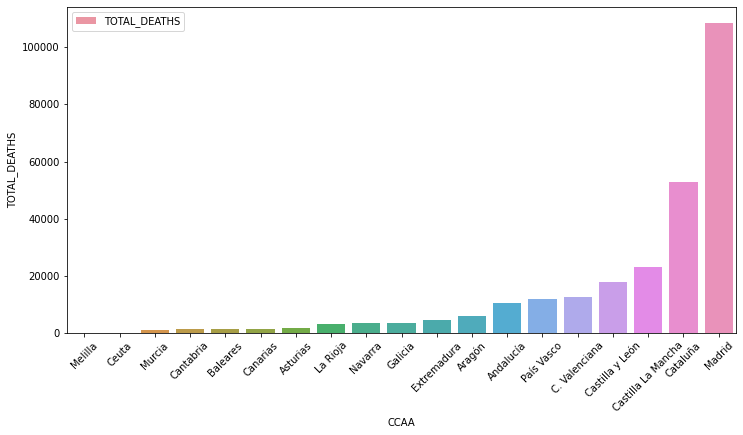

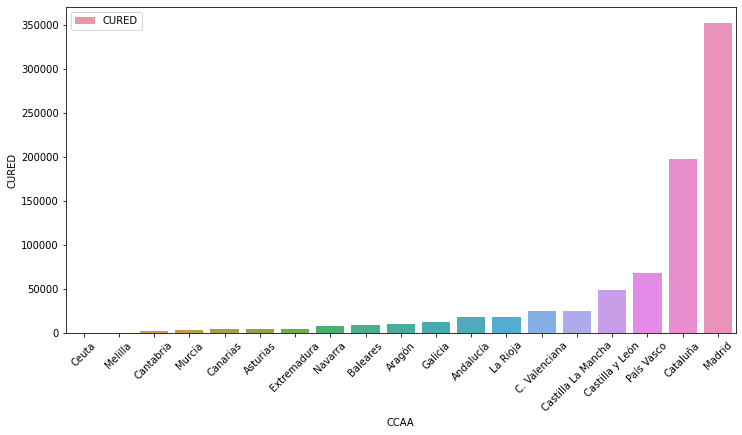

In [64]:
for c in df_ccaa.columns[1:-1]:
  plt.figure(figsize=(12,6))

  sns.barplot(df_ccaa.CCAA[np.argsort(df_ccaa[c])], df_ccaa[c][np.argsort(df_ccaa[c])], label=c)
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

In [58]:
df_time = df.groupby('DATE')[['TOTAL_INFECTED', 'REQUIERED_HOSPITALIZATION', 'TOTAL_DEATHS', 'CURED']].sum()
df_time.head()

,TOTAL_INFECTED,REQUIERED_HOSPITALIZATION,TOTAL_DEATHS,CURED
DATE,,,,
2020-02-20,2.0,0.0,0.0,0.0
2020-02-21,2.0,0.0,0.0,0.0
2020-02-22,2.0,0.0,0.0,0.0
2020-02-23,2.0,0.0,0.0,0.0
2020-02-24,3.0,0.0,0.0,0.0


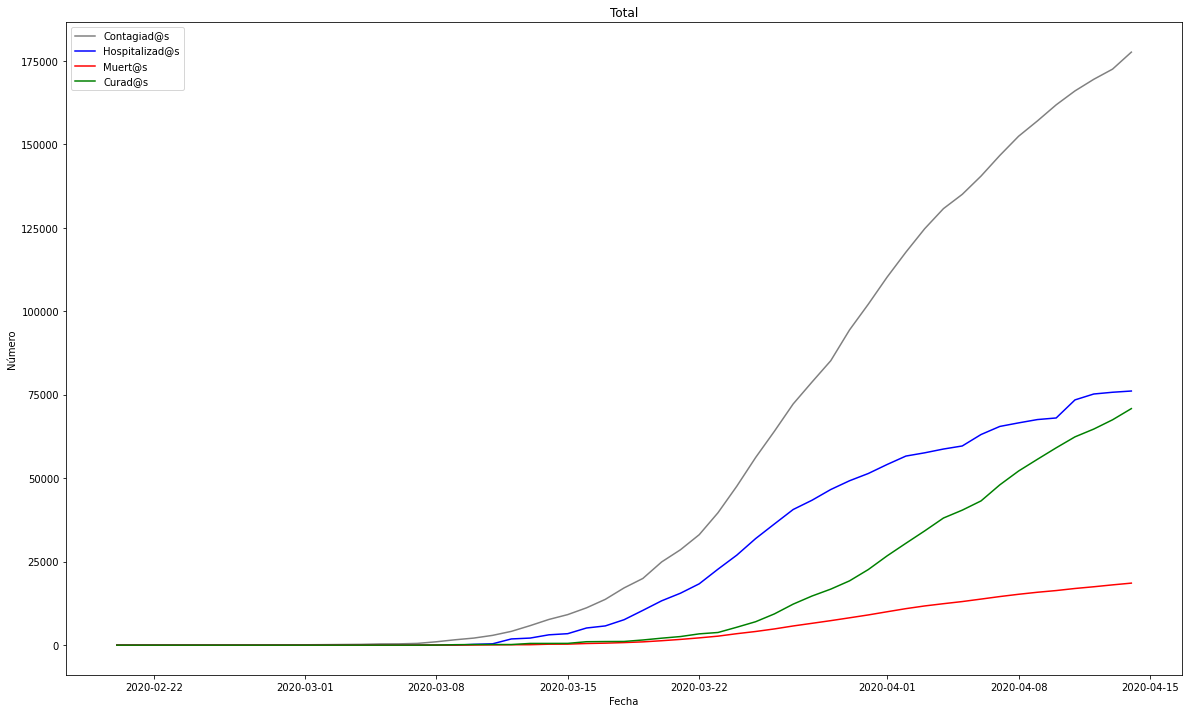

In [68]:
plt.figure(figsize=(20,12))
sns.lineplot(df_time.index, df_time.TOTAL_INFECTED, label='Contagiad@s', color='gray')
sns.lineplot(df_time.index, df_time.REQUIERED_HOSPITALIZATION, label='Hospitalizad@s', color='blue')
sns.lineplot(df_time.index, df_time.TOTAL_DEATHS, label='Muert@s', color='red')
sns.lineplot(df_time.index, df_time.CURED, label='Curad@s', color='green')

plt.title('Total')
plt.xlabel('Fecha')
plt.ylabel('Número')
plt.legend()
plt.show()

# **Castilla La Mancha**

In [0]:
df_c_l_m = df[df['id']==7]

In [0]:
df_c_l_m.head()

,id,CCAA,CCAA_for_Folium,DATE,DATE_for_Folium,TOTAL_INFECTED,REQUIERED_HOSPITALIZATION,REQUIERED_ADVANCED_CARE,TOTAL_DEATHS,CURED,Population,COLORS
6,7,Castilla La Mancha,Castilla-La Mancha,2020-02-20,1582156800,0.0,0.0,0.0,0.0,0.0,2032863,#FFFFFF
25,7,Castilla La Mancha,Castilla-La Mancha,2020-02-21,1582243200,0.0,0.0,0.0,0.0,0.0,2032863,#FFFFFF
44,7,Castilla La Mancha,Castilla-La Mancha,2020-02-22,1582329600,0.0,0.0,0.0,0.0,0.0,2032863,#FFFFFF
63,7,Castilla La Mancha,Castilla-La Mancha,2020-02-23,1582416000,0.0,0.0,0.0,0.0,0.0,2032863,#FFFFFF
82,7,Castilla La Mancha,Castilla-La Mancha,2020-02-24,1582502400,0.0,0.0,0.0,0.0,0.0,2032863,#FFFFFF


In [0]:
data_clm_dates = df_c_l_m.groupby('DATE')[['TOTAL_INFECTED', 'REQUIERED_HOSPITALIZATION', 'TOTAL_DEATHS', 'CURED']].sum()

In [0]:
data_clm_dates.head()

,TOTAL_INFECTED,REQUIERED_HOSPITALIZATION,TOTAL_DEATHS,CURED
DATE,,,,
2020-02-20,0.0,0.0,0.0,0.0
2020-02-21,0.0,0.0,0.0,0.0
2020-02-22,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0
2020-02-24,0.0,0.0,0.0,0.0


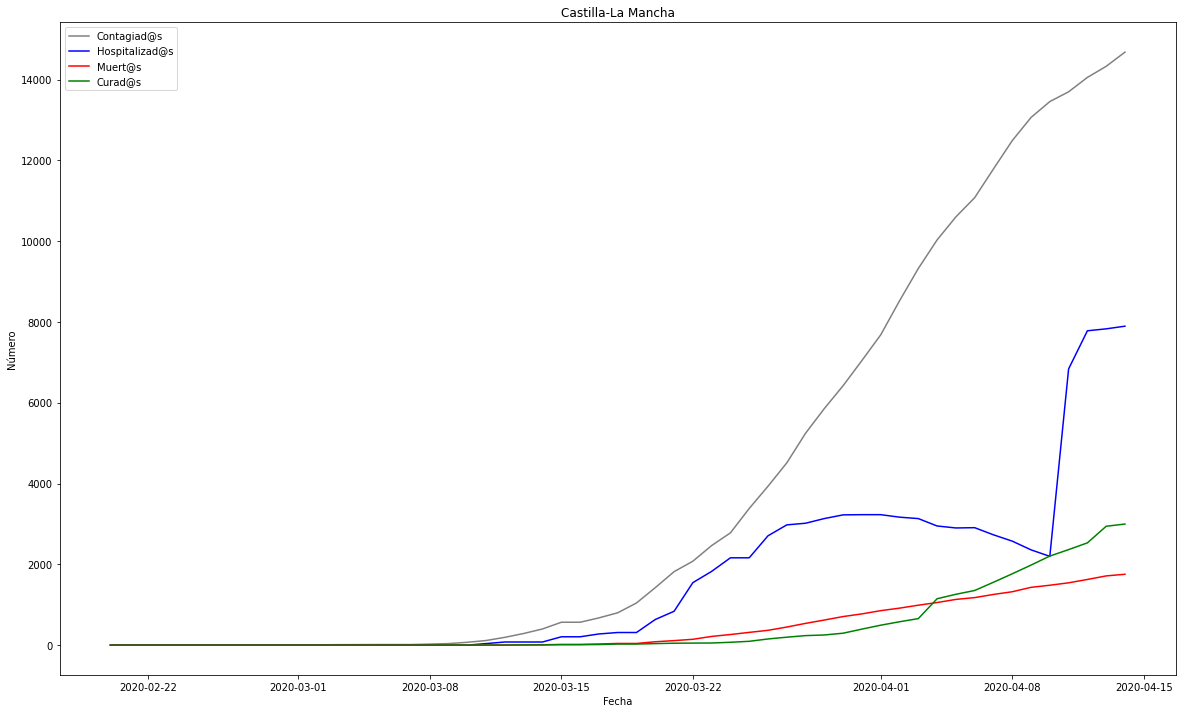

In [0]:
plt.figure(figsize=(20,12))
sns.lineplot(data_clm_dates.index, data_clm_dates.TOTAL_INFECTED, label='Contagiad@s', color='gray')
sns.lineplot(data_clm_dates.index, data_clm_dates.REQUIERED_HOSPITALIZATION, label='Hospitalizad@s', color='blue')
sns.lineplot(data_clm_dates.index, data_clm_dates.TOTAL_DEATHS, label='Muert@s', color='red')
sns.lineplot(data_clm_dates.index, data_clm_dates.CURED, label='Curad@s', color='green')

plt.title('Castilla-La Mancha')
plt.xlabel('Fecha')
plt.ylabel('Número')
plt.legend()
plt.show()

In [0]:
totals = df_c_l_m[['TOTAL_INFECTED', 'REQUIERED_HOSPITALIZATION', 'TOTAL_DEATHS', 'CURED']].sum()
totals['POPULATION'] = df_c_l_m.Population.unique()[0]

totals['INFECTED'] = (totals['TOTAL_INFECTED']/totals['POPULATION'])*100
totals['DEATHS'] = (totals['TOTAL_DEATHS']/totals['POPULATION'])*100
totals['CURED'] = (totals['CURED']/totals['POPULATION'])*100
totals['HOSPITALIZATION'] = (totals['REQUIERED_HOSPITALIZATION']/totals['POPULATION'])*100
totals['Healthy'] = 100 - totals['INFECTED'] - totals['DEATHS'] - totals['CURED'] - totals['HOSPITALIZATION']

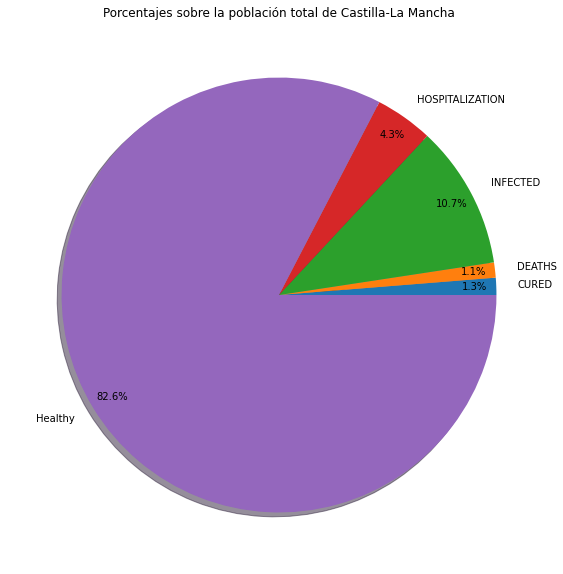

In [0]:
labels = ['CURED', 'DEATHS', 'INFECTED', 'HOSPITALIZATION', 'Healthy']
sizes = totals[labels]

plt.figure(figsize=(16,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        pctdistance=0.9, shadow=True)

plt.title('Porcentajes sobre la población total de Castilla-La Mancha')
plt.show()

In [0]:
totals['POPULATION']

2032863.0

In [0]:
(2035000*0.05)

101750.0